In [4]:
import pandas as pd
import time
import jieba

## Read Files

读取标注数据，分析并清理数据

In [5]:
data = pd.read_excel('data/labeled_csc_0.xlsx', header=None)

In [6]:
file=['data/labeled_csc_0.xlsx','data/labeled_csc_1.xlsx','data/labeled_csc_2.xlsx',
      'data/labeled_csc_3.xlsx','data/labeled_csc_4.xlsx','data/labeled_csc_5.xlsx',
      'data/labeled_csc_6.xlsx','data/labeled_csc_7.xlsx','data/labeled_csc_8.xlsx',
      'data/labeled_csc_9.xlsx','data/labeled_csc_10.xlsx','data/labeled_csc_11.xlsx',
      'data/labeled_csc_12.xlsx','data/labeled_csc_13.xlsx','data/labeled_csc_14.xlsx',
      'data/labeled_csc_15.xlsx','data/labeled_csc_16.xlsx']
li=[]
for i in file:
    li.append(pd.read_excel(i, header=None))
data = pd.concat(li)

In [7]:
data.shape

(192954, 4)

#### 有11条多一列，可能是需要注意的意图

In [8]:
data[(~data[3].isnull())]

,0,1,2,3
10011,66743098.0,那我得去315投诉你们了,0,投诉315
10666,66046299.0,点评平台工作人员您好。我是13704660580的用户，黑龙江大庆市的新闻工作者慕月。我申诉...,0,曝光
11037,63472006.0,到底能不能解决。实在不能解决我就再次联系消费者协会投诉服务热线了。投诉大众点评,1,投诉消协
11061,66185300.0,我要向，我们当地的媒体投诉你们,0,曝光媒体
11064,66346632.0,如果不好好处理我去消协网站上投诉,1,曝光媒体
11232,60275966.0,要不直接通过12315投诉,1,投诉315
11305,67014912.0,我现在没有了，我打12315电话投诉了，后来才让我走的。,1,投诉315
11372,66700943.0,还是找工商部门投诉,1,投诉工商
11480,67118211.0,一起团的姐妹已退款，可以看一下理由是商家不接待。我因为当时向工商局投诉了就没退款等待工商局处...,1,投诉工商
11530,63887532.0,不给处理好，微博，贴吧全程曝光，你们就找这种商家合作吗,0,微博曝光


In [9]:
data = data.drop([0,3],axis=1)
data.columns = ['content', 'label']

#### Label: 0 愤怒  ，1 不满， 2 中性 ，3 满意， 4 赞扬

In [10]:
print('总共对话数据{}条:\n'.format(data.shape[0]))
print('愤怒 数据{}条\n不满 数据{}条\n中性 数据{}条\n满意 数据{}条\n赞扬 数据{}条'.format(data[data['label']==0].shape[0],
                                                        data[data['label']==1].shape[0],data[data['label']==2].shape[0],
                                                        data[data['label']==3].shape[0],data[data['label']==4].shape[0]))

总共对话数据192954条:

愤怒 数据11752条
不满 数据56811条
中性 数据104196条
满意 数据4057条
赞扬 数据331条


In [84]:
import matplotlib.pyplot as plt
data_cate = [data[data['label']==0].shape[0], data[data['label']==1].shape[0],data[data['label']==2].shape[0],
             data[data['label']==3].shape[0],data[data['label']==4].shape[0]]

Text(0.5,1,'Category Distribution')

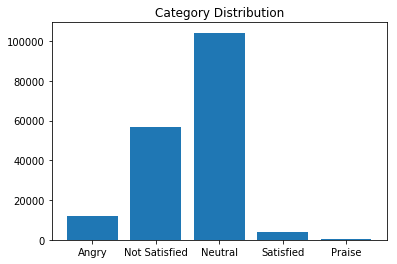

In [92]:
plt.bar(['Angry', 'Not Satisfied', 'Neutral', 'Satisfied', 'Praise'],data_cate)
plt.title('Category Distribution')

#### 赞扬 急需数据增强

In [11]:
praise = data[data['label']==4]
praise.head()

,content,label
2994,优质服务，赞一个！,4
4005,谢谢！非常感谢,4
4559,为您美团的效率点赞,4
5732,我已经收到退款了，太谢谢了，本来是给我朋友买的，他到不了。总之很谢谢啦[鲜花][鲜花][鲜花...,4
11597,对，给你个赞,4


#### 去重

In [12]:
praise = praise.drop_duplicates()

#### 清理html

In [13]:
import re
def remove_html(string):
   pattern_list = [
       '<(img|div)?.*>?',
       '<(img|div|span|url)[-A-Za-z0-9+&@#/%?=~_!:,.;"sr…… ]+',
       '<(div|ul|url|body|html|b|p|img|span|a)+.*/(div|ul|url|body|html|b|p|img|span|a)>',
       '(https?|ftp|file)://[-A-Za-z0-9+&@#/%?=~_|!:,.;]+[-A-Za-z0-9+&@#/%=~_|]'
   ]
   for pattern in pattern_list:
       temp = re.search(pattern, string)
       if temp != None:
           result = temp.group(0)
           string = string.replace(result, '')
   return string

In [14]:
praise['content'] = praise.content.map(lambda x: remove_html(x))

# Augmentation by Translation

**Main Idea:**  

    Using round-translation( translate sentence from source language to target language and then translate it back to source language ) to obtain more sentences.
    
**Implementation:**  

    Requesting the google translation service, there are some tricks in requesting url:  
        1. Google calculate a token according to different translation content by js.
        2. Requesting interval need to be reasonable or google will cease taking requests.
        3. Languages from different origin can obtain more diverse result.
        
**Some tricks:**  

    1. Requesting interval set to 3-5 seconds.
    2. Adding random seconds to make request interval to be different, avoid being detected.
    3. Prevent urlopen request time out.
    4. Avoid some rare language to ensure response efficiency.
    5. Save partial results from time to time, prevent unstable network causing result loss.

### Request functions

In [81]:
"""
Calculating tokens from content by js
"""
import execjs
class Py4Js():
    
    def __init__(self):
        self.ctx = execjs.compile("""
        function TL(a) {
        var k = "";
        var b = 406644;
        var b1 = 3293161072;
        
        var jd = ".";
        var $b = "+-a^+6";
        var Zb = "+-3^+b+-f";
    
        for (var e = [], f = 0, g = 0; g < a.length; g++) {
            var m = a.charCodeAt(g);
            128 > m ? e[f++] = m : (2048 > m ? e[f++] = m >> 6 | 192 : (55296 == (m & 64512) && g + 1 < a.length && 56320 == (a.charCodeAt(g + 1) & 64512) ? (m = 65536 + ((m & 1023) << 10) + (a.charCodeAt(++g) & 1023),
            e[f++] = m >> 18 | 240,
            e[f++] = m >> 12 & 63 | 128) : e[f++] = m >> 12 | 224,
            e[f++] = m >> 6 & 63 | 128),
            e[f++] = m & 63 | 128)
        }
        a = b;
        for (f = 0; f < e.length; f++) a += e[f],
        a = RL(a, $b);
        a = RL(a, Zb);
        a ^= b1 || 0;
        0 > a && (a = (a & 2147483647) + 2147483648);
        a %= 1E6;
        return a.toString() + jd + (a ^ b)
    };
    
    function RL(a, b) {
        var t = "a";
        var Yb = "+";
        for (var c = 0; c < b.length - 2; c += 3) {
            var d = b.charAt(c + 2),
            d = d >= t ? d.charCodeAt(0) - 87 : Number(d),
            d = b.charAt(c + 1) == Yb ? a >>> d: a << d;
            a = b.charAt(c) == Yb ? a + d & 4294967295 : a ^ d
        }
        return a
    }
    """)
        
    def getTk(self,text):
        return self.ctx.call("TL",text)


In [16]:
"""
Concat url and sending request
"""

import urllib.request 
import random
  
def open_url(url):  
    headers = {'User-Agent':'Mozilla/5.0 (Windows NT 6.1; WOW64; rv:23.0) Gecko/20100101 Firefox/23.0'}    
    req = urllib.request.Request(url = url,headers=headers)  
#     response = urllib.request.urlopen(req)

    global Max_Num
    Max_Num=10
    for i in range(Max_Num):
        try:
            response = urllib.request.urlopen(req)
            break
        except:
            if i < Max_Num-1:
                continue
            else :
                print('URLError: <urlopen error timed out> All times is failed ')
                    
    data = response.read().decode('utf-8')  
    return data  
  
def translate(content,tk, source, target):  
    if len(content) > 4891:  
        print("翻译的长度超过限制！！！")  
        return   
      
    content = urllib.parse.quote(content)  
      
    url = "http://translate.google.com/translate_a/single?client=t&sl="+source+"&tl="+target+"&hl="+target+ "&dt=at&dt=bd&dt=ex&dt=ld&dt=md&dt=qca&dt=rw&dt=rm&dt=ss&dt=t&ie=UTF-8&oe=UTF-8&clearbtn=1&otf=1&pc=1&srcrom=0&ssel=0&tsel=0&kc=2&tk=%s&q=%s"%(tk,content)  
    
    time.sleep(1 + random.random())
    result = open_url(url)  
      
    end = result.find("\",")  
    if end > 4:  
#         print(result[4:end]) 
        return result[4:end]
    

In [17]:
"""
Round-translation
"""

def trans(content, tl):
    js = Py4Js() 
    
    sl = 'zh-CN'
    tk = js.getTk(content)
    mid = translate(content,tk, sl, tl)
    mid = clean(mid)
    time.sleep(3)
#     print(tl, mid)
    tk = js.getTk(mid)
    return translate(mid,tk, tl, sl)

In [20]:
"""
Round-translate in multiple languages
"""
def multi_trans(content):
    res = []
    js = Py4Js() 
    
    res.append(trans(content, 'en'))
    res.append(trans(content, 'ja'))
    res.append(trans(content, 'th'))
    res.append(trans(content, 'es'))
    res.append(trans(content, 'fr'))
    res.append(trans(content, 'ru'))
    res.append(trans(content, 'uk'))
    res.append(trans(content, 'sv'))
    res.append(trans(content, 'sr'))
#     res.append(trans(content, 'sq'))
    res.append(trans(content, 'ro'))
#     res.append(trans(content, 'pt'))
#     res.append(trans(content, 'pl'))
    res.append(trans(content, 'no'))
    res.append(trans(content, 'nl'))
    res.append(trans(content, 'ko'))
    res.append(trans(content, 'lt'))
    res.append(trans(content, 'it'))
    res.append(trans(content, 'hr'))
    res.append(trans(content, 'de'))
     
    return res

### Clean punctuations to avoid partial tranlation
  
Google will cut sentences by punctuations, to avoid getting partial results, substitute these punctuations to comma.

In [18]:
import re
def clean(sent):
    clean_s = re.sub("[。；;!！？?.]",",",sent)
    clean_s = re.sub('&nbsp', ",", clean_s)
    clean_s = re.sub('&#x1f61c', " ", clean_s)
    clean_s = re.sub('&#x1f444', " ", clean_s)   
    return clean_s

In [21]:
praise['content'] = praise.content.map(lambda x: clean(x))

### Round-translation E.g.

In [19]:
trans('今天天气还真不错', 'ru')

'今天天气很好，'

In [27]:
content = '你们的服务太好了，我好开心啊'
res = pd.DataFrame(multi_trans(content))
print('Content Length is {} (jieba cut), has {} duplicated result.'.format( len(list(jieba.cut(content))),res.duplicated().sum()))

en Your service is so good, I am so happy,
ja あなたのサービスはとても良いです、私はとても幸せです,
th บริการของคุณดีมากฉันมีความสุขมาก
es Tu servicio es tan bueno, estoy tan feliz,
fr Votre service est si bon, je suis si heureux,
ru Ваше служение так хорошо, я так счастлив,
uk Ваш сервіс настільки хороший, я так щаслива,
sv Din tjänst är så bra, jag är så glad,
sr Твоја служба је тако добра, тако сам срећна,
ro Serviciul tău este atât de bun, sunt atât de fericit,
pl Twoja służba jest tak dobra, jestem taka szczęśliwa,
no Din tjeneste er så bra, jeg er så glad,
nl Jouw service is zo goed, ik ben zo blij,
ko 너의 서비스는 너무 좋고, 나는 너무 행복해,
lt Jūsų paslauga yra tokia gera, aš esu labai laiminga,
it Il tuo servizio è così buono, sono così felice,
hr Vaša je usluga tako dobra, sretna sam,
de Dein Service ist so gut, ich bin so glücklich,
Content Length is 8 (jieba cut), has 14 duplicated result.


In [24]:
praise_idx = praise.reset_index()

In [25]:
praise_idx[praise_idx['index'] == 3361]

,index,content,label
56,3361,"好的,非常感谢你耐心解决我的问题,后续开立分店后如果遇到问题我会继续咨询的,另外也建议可以专...",4


#### Get round-translate and drop duplicates

In [118]:
total = []
aug_amount = []
for content in praise['content'].tolist():
    res = pd.DataFrame(multi_trans(content))
    res = res.drop_duplicates()
    aug_amount.append(res.shape[0])
    total.append(res[0].tolist())
    print(content, 'Done')

en Excellent service, like one,
ja 優れたサービス、1つのような、
th บริการที่ยอดเยี่ยมเช่นเดียวกับ
es Excelente servicio, como uno,
fr Excellent service, comme un,
ru Отличное обслуживание,
uk Відмінний сервіс, як і один,
sv Utmärkt service, som en,
sr Одлична услуга, попут оне,
ro Servicii excelente, ca unul,
pl Doskonała usługa, taka jak ta,
no Utmerket service, som en,
nl Uitstekende service, zoals een,
ko 우수한 서비스, 하나 같이,
lt Puiki paslauga, tokia kaip viena
it Servizio eccellente, come uno,
hr Izvrsna usluga, poput jednog,
de Exzellenter Service, wie ein,
优质服务，赞一个, Done
en Thank you very much
ja ありがとう、ありがとう,
th ขอบคุณมากครับ
es Gracias, muchas gracias,
fr Merci, merci beaucoup,
ru Благодарю вас, большое спасибо,
uk Дякую вам, дякую вам дуже,
sv Tack, tack så mycket,
sr Хвала, хвала вам пуно,
ro Mulțumesc, vă mulțumesc foarte mult,
pl Dziękuję, dziękuję bardzo,
no Takk, tusen takk,
nl Bedankt, heel erg bedankt,
ko 고마워요, 고마워요,
lt Ačiū, labai jums ačiū,
it Grazie, molte grazie,
hr Hvala vam, hvala v

KeyboardInterrupt: 

#### Starting from last breakpoint

In [35]:
total1 = []
for i in range(320, len(praise_idx['content'].tolist())):
    content = praise_idx['content'].tolist()[i]
    res = pd.DataFrame(multi_trans(content))
    res = res.drop_duplicates()
    total1.append(res[0].tolist())
    print(i, content, 'Done')

320 商家态度很好,, Done


#### Write down 

In [58]:
total_list = []
for s in total1:
    total_list.extend(s)

In [34]:
pd.DataFrame(total_list).to_csv('trans_83-319.csv')

#### Concat the result

In [52]:
pd1 = pd.read_csv('trans_56.csv')
pd2 = pd.read_csv('trans_57-82.csv')
pd3 = pd.read_csv('trans_83-319.csv')

In [53]:
pd1 = pd1.drop('Unnamed: 0', axis=1)
pd2 = pd2.drop('Unnamed: 0', axis=1)
pd3 = pd3.drop('Unnamed: 0', axis=1)

In [63]:
pd4 = pd.DataFrame(total_list)

In [68]:
pd4.columns=['0']

In [70]:
total_res = pd.concat([pd1,pd2,pd3,pd4], axis=0)

In [72]:
total_res = total_res.reset_index()
total_res = total_res.drop(['index'], axis=1)

In [76]:
label = pd.DataFrame([4]*total_res.shape[0])
res = pd.concat([total_res,label], axis=1)
res.columns = ['content', 'label']

In [77]:
res.head()

,content,label
0,优质的服务，就像一个，,4
1,优质的服务。,4
2,优质的服务，如一个，,4
3,优质的服务，,4
4,优质的服务，就像一个,4


In [80]:
res.to_csv('translation_praise_2698.csv')

# Augmentation by thesaurus substitution

#### 给出一个词，反查到对应同义词组
  
thesaurus_all：存储同义词组  
word_dict： key是词语，value是同义词组中的索引

### 读取同义词词组

In [70]:
thesaurus_all = []
with open('thesaurus_dict.txt', 'r') as f:
     thesaurus_all = f.read().splitlines()

### 同义词词典：词语-同义词词组索引

In [78]:
word_dict = {}
for i in range(len(thesaurus_all)):
    words_list = thesaurus_all[i]
    for word in words_list.split(','):
        word_dict[word] = i


### E.g.

In [91]:
search = word_dict['可以']
print('index in thesaurus_all:', search)
print('thesaurus list:',thesaurus_all[search].split(','))

index in thesaurus_all: 5594
thesaurus list: ['能够', '可以', '或许']


1. 长句要替换足够多的词才能算是新句  
2. 替换的组合方式？

### Helper Function

In [398]:
"""
Input: 
origin_sent: sentence to be augmented, 
word_dict: word - synonym index
thesaurus_all: synonym 

Output:
aug_sentences: Augmented sentences (list)

This function takes in the original sentence, 
cut by jieba and find words that can be substituted and substitution choices.

According to the ratio between length of original sentence and the amount of substitution words' count, 
The augmented sentences will be generated by substituting 1,2,3 words.

"""

def aug_sent(origin_sent, word_dict, thesaurus_all):
    sub_count = 0
    choices = {}
    origin_sent_list = list(jieba.cut(origin_sent))
    for word in origin_sent_list:
        if word in word_dict.keys():
            sub_count += 1
            thesaurus_list = thesaurus_all[word_dict[word]].split(',')
            choice = []
    #         print(word,':', thesaurus_all[word_dict[word]].split(','))
            for w in thesaurus_list:
                if word == w: 
                    continue
                else: choice.append(w)
    #         print(word, 'substitution choice:',choice)
            choices[word] = choice

    # print('original sent len:', len(origin_sent_list))
    # print('substituable word counts:', sub_count)
    # print(choices)

    aug_sentences = []

    if len(choices) == 0: 
        return aug_sentences
    # 如果 原句词数量/可替换的词数量 > 3 则至少替换三个词才能算新句子
    elif len(origin_sent_list)/float(len(choices)) > 3:
        aug_sentences = sub3(origin_sent_list, choices)

    # 如果 3 > 原句词数量/可替换的词数量 > 2 则至少替换两个词才能算新句子
    elif len(origin_sent_list)/float(len(choices)) > 2:
        aug_sentences = sub2(origin_sent_list, choices)

    else: aug_sentences = sub1(origin_sent_list, choices)

#     print('\naug_amount:',len(aug_sentences))
    return aug_sentences

In [291]:
# origin_sent = '感谢您态度这么好 但上架活动务必有专人跟踪反馈 不然多少人被忽悠过去又花冤枉钱 主要心里很不愉快'
# print('original sentence:{}\n'.format(list(jieba.cut(origin_sent))))

# sub_count = 0
# choices = {}
# origin_sent_list = list(jieba.cut(origin_sent))
# for word in origin_sent_list:
#     if word in word_dict.keys():
#         sub_count += 1
#         thesaurus_list = thesaurus_all[word_dict[word]].split(',')
#         choice = []
# #         print(word,':', thesaurus_all[word_dict[word]].split(','))
#         for w in thesaurus_list:
#             if word == w: 
#                 continue
#             else: choice.append(w)
# #         print(word, 'substitution choice:',choice)
#         choices[word] = choice

# print('original sent len:', len(origin_sent_list))
# print('substituable word counts:', sub_count)
# print(choices)

# aug_sentences = []
# # 如果 原句词数量/可替换的词数量 > 2 则至少替换两个词才能算新句子
# if len(origin_sent_list)/float(len(choices)) > 3:
#     aug_sentences = sub3(origin_sent_list, choices)
# elif len(origin_sent_list)/float(len(choices)) > 2:
#     aug_sentences = sub2(origin_sent_list, choices)
# else: aug_sentences = sub1(origin_sent_list, choices)
    
# print('\naug_amount:',len(aug_sentences))

original sentence:['感谢您', '态度', '这么', '好', ' ', '但', '上架', '活动', '务必', '有', '专人', '跟踪', '反馈', ' ', '不然', '多少', '人', '被', '忽悠', '过去', '又', '花', '冤枉钱', ' ', '主要', '心里', '很', '不', '愉快']

original sent len: 29
substituable word counts: 8
{'态度': ['立场'], '活动': ['运动'], '不然': ['否则'], '多少': ['很多', '好多', '许多', '良多'], '过去': ['已往'], '主要': ['首要'], '心里': ['内心'], '愉快': ['兴奋']}

aug_amount: 422


### Substitution Functions

In [219]:
"""
Input:
origin_sent_list: cutted original sentence word list
s: word that will be substituted
sub_list: substitution choices

Output:
new_sents: generated new sentences in list

"""

import copy
def sub(origin_sent_list, s, sub_list):
    new_sents = []
    for i in range(len(origin_sent_list)):
        if origin_sent_list[i] == s:
            for sub_w in sub_list:
                new_sent_list = copy.copy(origin_sent_list)
                new_sent_list[i] = sub_w
                new_sents.append(new_sent_list)
#                 new_sents.append(''.join(new_sent_list))
    return new_sents

#### E.g.

In [205]:
# origin_sent = '感谢您态度这么好 但上架活动务必有专人跟踪反馈 不然多少人被忽悠过去又花冤枉钱 主要心里很不愉快'
# origin_sent_list = list(jieba.cut(origin_sent))
# sub(origin_sent_list, '多少', choices['多少'])

In [484]:
"""
substitute only one word with all choices
"""

# sub1(origin_sent_list, choices)
def sub1(origin_sent_list, choices):
    choices_list = list(choices.keys())
    all_list = []
    for i in range(len(choices_list)):
        all_list.extend(sub(origin_sent_list, choices_list[i], choices[choices_list[i]]))

    all_new = []
    for s_list in all_list:
        all_new.append(''.join(s_list))
    return all_new

In [249]:
"""
substitute two words
"""

# sub2(origin_sent_list, choices)
def sub2(origin_sent_list, choices):
    choices_list = list(choices.keys())
    all_list = []
    for i in range(len(choices_list)):
        j = i
        for j in range(j+1,len(choices_list)-1):
#             print(choices_list[i],choices_list[j])
            sub_first = sub(origin_sent_list, choices_list[i], choices[choices_list[i]])
#             print('first',sub_first)
            for sent in sub_first:
                all_list.extend(sub(sent, choices_list[j], choices[choices_list[j]]))
#             print('all',all_list)
#             print(len(all_list))

    all_new = []
    for s_list in all_list:
        all_new.append(''.join(s_list))
    return all_new

In [279]:
"""
substitute three words
"""

# sub3(origin_sent_list, choices)
def sub3(origin_sent_list, choices):
    choices_list = list(choices.keys())
    sub_second = []
    all_list = []
    for i in range(len(choices_list)):
        j = i
        for j in range(j+1,len(choices_list)-1):
            sub_first = sub(origin_sent_list, choices_list[i], choices[choices_list[i]])
            for sent in sub_first:
                sub_second.extend(sub(sent, choices_list[j], choices[choices_list[j]]))
            k = j

            for k in range(k+1, len(choices_list)-1):
    #             print(choices_list[i],choices_list[j], choices_list[k])
                for sent in sub_second:
                    all_list.extend(sub(sent, choices_list[k], choices[choices_list[k]]))
    #         print(len(all_list))

    all_new = []
    for s_list in all_list:
        all_new.append(''.join(s_list))
    return all_new

## Main

#### print out the sentences that has more than 1000 aug amounts


In [478]:
total_aug = pd.DataFrame()
aug_amount = []
sent_list = praise['content'].tolist()
sent_list[15] = '和闺蜜一起过来纹眉的，刚开始怕很生硬，怕不自然，很紧张。跟JESS老师沟通后，还是很信任的做了，照片拍不出感觉，真的很自然，跟画了淡淡的眉粉淡妆一样，很喜欢呀。'
for sent in sent_list:  
#     print(sent)
    aug_sentences = aug_sent(sent, word_dict, thesaurus_all)
    if(len(aug_sentences) == 0):
        continue
    if len(aug_sentences)>1000:
        print(sent)
    aug_sentences_df = pd.DataFrame(aug_sentences).drop_duplicates()
    total_aug = total_aug.append(aug_sentences_df)
    aug_amount.append(aug_sentences_df.shape[0])
print('Total Augmented Amount:', total_aug.shape[0])

和闺蜜一起过来纹眉的，刚开始怕很生硬，怕不自然，很紧张。跟JESS老师沟通后，还是很信任的做了，照片拍不出感觉，真的很自然，跟画了淡淡的眉粉淡妆一样，很喜欢呀。
哦，那算了吧，碰上那个碰瓷的，又遇到你们大众点评网这个平台，我只能认倒霉了，唉，不过还是要谢谢您，回答问题有耐心
好的。非常感谢你耐心解决我的问题。后续开立分店后如果遇到问题我会继续咨询的。另外也建议可以专门制作一个分店的操作手册。这样有需求的商家可以直接阅读手册，减少客服的工作量。
四月三十号我们在美团网预订了如家魅力海景公寓四天，五一到了这家海景公寓，因特殊情况我们需要退房间，美团客服获悉我们的诉求后，经过认真沟通和耐心协调，妥善处理了此事。感谢美团的官方领导！感谢美团的运营工作人员！感谢美团的客服人员！
四月三十号我们在美团网预订了青岛的如家魅力海景公寓四天，五一到了这家海景公寓，因特殊情况我们需要退房间，美团客服获悉我们的诉求后，经过认真沟通和耐心协调，妥善处理了此事。感谢美团的官方领导！感谢美团的运营工作人员！感谢美团的客服人员！
好吧。。。虽然问题可能还是无法解决 但还是要谢谢你这么耐心的帮我 给你个好评
Total Augmented Amount: 6423


### Analysis and Write Down

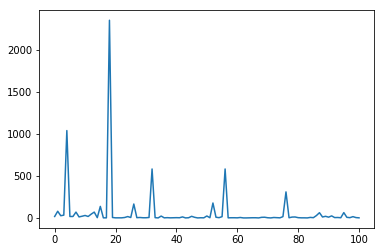

In [481]:
import matplotlib.pyplot as plt
plt.plot(aug_amount)

In [482]:
sent = '好的。非常感谢你耐心解决我的问题。后续开立分店后如果遇到问题我会继续咨询的。另外也建议可以专门制作一个分店的操作手册。这样有需求的商家可以直接阅读手册，减少客服的工作量。'
len(aug_sent(sent, word_dict, thesaurus_all))

33955

In [492]:
label = pd.DataFrame([4]*total_aug.shape[0])
total_aug = total_aug.reset_index()
total_aug = total_aug.drop(['index'], axis=1)
res = pd.concat([total_aug,label], axis=1)
res = res.drop(['level_0'], axis=1)
res.columns = ['content', 'label']

In [510]:
res.head()

,content,label
0,固然我很气愤，但是还是要对你的服务点个赞,4
1,固然我很愤恚，但是还是要对你的服务点个赞,4
2,当然我很气愤，但是还是要对你的服务点个赞,4
3,当然我很愤恚，但是还是要对你的服务点个赞,4
4,固然我很生气，然则还是要对你的服务点个赞,4


In [497]:
res.to_csv('substitution_praise_6423.csv')